# AutoEncoder-based Model

## AE

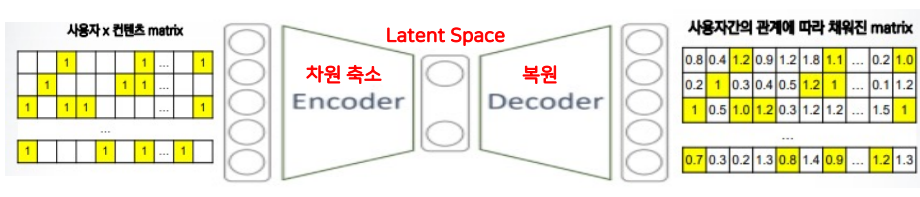

사용자가 매긴 평점을 바탕으로 인코딩과 디코딩을 통해서 ? 부분을 유추해내는 방식

input = 행 - 사용자, 열 - 영화, 값 - 평점

output = 사용자가 보지 않은 영화의 평점을 추론하여 영화를 추천

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta.rename(columns={'id':'movieId'})

In [ ]:
movie.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], on='movieId')
movie.head()

,userId,movieId,rating,timestamp,original_title
0,1,1371,2.5,1260759135,Rocky III
1,4,1371,4.0,949810302,Rocky III
2,7,1371,3.0,851869160,Rocky III
3,19,1371,4.0,855193404,Rocky III
4,21,1371,3.0,853852263,Rocky III


In [ ]:
df = movie.pivot_table(index='userId', columns = 'movieId', values = 'rating').fillna(0)
df.head()

movieId,100,100017,100032,100272,100450,101,101362,1018,101904,102,102165,1023,1024,103,103048,103210,103299,103502,103539,103688,103731,104,1040,104211,104241,104374,104863,1049,105,1050,1051,105121,105246,105254,105593,105763,1059,106417,107,107081,...,956,957,95744,95752,95949,95963,96,961,962,963,964,965,966,968,96821,97,97593,976,97936,97938,98,980,981,98122,982,98369,984,98491,986,98604,987,988,99,990,991,99106,992,994,996,99846
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
R = df.iloc[:, : ].values

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [ ]:
# 학습 조건 설정
BATCH_SIZE = 64
EPOCHS = 10

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):

  # 데이터 정의
  def __init__(self, x_data, y_data = None):
    self.x_data = x_data
    self.y_data = y_data

  # 이 데이터 셋의 총 데이터 수
  def __len__(self):
    return len(self.x_data)

  # 어떠한 idx를 받았을 때 그에 맞는 데이터를 반환
  def __getitem__(self, idx):
    if self.y_data is None:
      x = torch.Tensor(self.x_data[idx])
      return x
    else:
      x = torch.Tensor(self.x_data[idx])
      y = torch.Tensor(self.y_data[idx])
      return x, y

In [ ]:
# AutoEncoder 모델 설계
class AE(nn.Module):
  def __init__(self):
    super(AE, self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(2830, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 32)
    )

    self.decoder = nn.Sequential(
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 2830)
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [ ]:
def train(model, train_loader):
  model.train()
  train_loss = 0

  for batch_idx, (feature) in enumerate(train_loader):

    feature = feature.to(DEVICE)
    target = feature.to(DEVICE)
    optimizer.zero_grad()
    encoded, decoded = model(feature)
    loss = criterion(decoded, target)
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item()

  train_loss /= len(train_loader)
  return train_loss

In [ ]:
# 모델 정의
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=2830, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2830, bias=True)
  )
)


In [ ]:
train_dataset = CustomDataset(R)

train_loader = DataLoader(
  train_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False)

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}")


[EPOCH: 1], 	Train Loss: 0.2913

[EPOCH: 2], 	Train Loss: 0.2677

[EPOCH: 3], 	Train Loss: 0.2581

[EPOCH: 4], 	Train Loss: 0.2472

[EPOCH: 5], 	Train Loss: 0.2355

[EPOCH: 6], 	Train Loss: 0.2306

[EPOCH: 7], 	Train Loss: 0.2277

[EPOCH: 8], 	Train Loss: 0.2299

[EPOCH: 9], 	Train Loss: 0.2281

[EPOCH: 10], 	Train Loss: 0.2292


In [ ]:
def evaluate(model, train_loader):
  model.eval()
  result = []

  with torch.no_grad():

    for feature in train_loader:
      feature = feature.to(DEVICE)
      _, decoded = model(feature)
      result.append(decoded.cpu().numpy())

  result = np.concatenate(result)

  return result

result = evaluate(model, train_loader)
result

array([[ 0.03414949, -0.00705559, -0.01245978, ...,  0.00981715,
        -0.0072503 , -0.00445226],
       [-0.17716849,  0.05056265,  0.02536668, ..., -0.08960695,
         0.08169347, -0.0778148 ],
       [-0.00573398,  0.00499678, -0.01650207, ...,  0.00198242,
        -0.01964105, -0.01075399],
       ...,
       [ 0.01516606, -0.01361931, -0.01914574, ...,  0.0276698 ,
        -0.0256141 , -0.00381552],
       [ 0.0179247 ,  0.00132252, -0.02694143, ...,  0.05192481,
        -0.01880549, -0.01678251],
       [ 0.00644503,  0.03192773, -0.0186066 , ...,  0.02419448,
        -0.04850829, -0.04290579]], dtype=float32)

In [ ]:
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## VAE

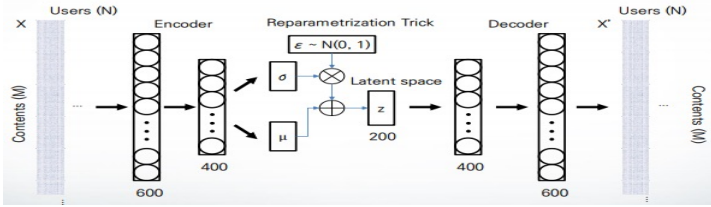

사용자의 영화 시청 여부를 바탕으로 인코딩과 디코딩을 통해서 ? 부분을 유추해내는 방식

input = 행 - 사용자, 열 - 영화, 값 - 시청 여부

output = 사용자가 보지 않은 영화에 대하여 추론하여 볼 확률이 높다면 영화를 추천

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta.rename(columns={'id':'movieId'})

In [ ]:
movie.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], on='movieId')
movie['one'] = 1
movie.head()

,userId,movieId,rating,timestamp,original_title,one
0,1,1371,2.5,1260759135,Rocky III,1
1,4,1371,4.0,949810302,Rocky III,1
2,7,1371,3.0,851869160,Rocky III,1
3,19,1371,4.0,855193404,Rocky III,1
4,21,1371,3.0,853852263,Rocky III,1


In [ ]:
df = movie.pivot_table(index='userId', columns = 'original_title', values = 'one').fillna(0)
df.head()

original_title,!Women Art Revolution,'Gator Bait,'Twas the Night Before Christmas,...Più forte ragazzi!,00 Schneider - Jagd auf Nihil Baxter,10 Items or Less,10 Things I Hate About You,"10,000 BC",11'09''01 - September 11,12 + 1,12 Angry Men,13 Tzameti,1408,15 Minutes,16 Blocks,1724 기방난동사건,1942: A Love Story,1984,2 Days in Paris,"20,000 Leagues Under the Sea",2001: A Space Odyssey,2010,2046,2061 - Un anno eccezionale,21 Grams,24 Hour Party People,25th Hour,28 Days Later,28 Weeks Later,29th Street,2:37,3 Ninjas: High Noon at Mega Mountain,3 hommes et un couffin,300,33 sceny z życia,36 Fillette,"4 luni, 3 săptămîni și 2 zile",40 Days and 40 Nights,42nd Street,48 Hrs.,...,真夜中の弥次さん喜多さん,続宮本武蔵 一乗寺の決闘,綠草地,纵横四海,羅生門,英雄,菊次郎の夏,薔薇の葬列,蜘蛛巣城,裸の島,誰も知らない,豚と軍艦,赤ひげ,野火,鎗王之王,隠し砦の三悪人,風の谷のナウシカ,香港製造,鬼婆,鷹爪鐵布衫,거룩한 계보,고지전,공동경비구역 JSA,괴물,김복남 살인사건의 전말,다세포 소녀,도쿄!,밀양,봄 여름 가을 겨울 그리고 봄,빈집,사마리아,야수,연가시,오직 그대만,올드보이,"장화, 홍련",최종병기 활,친절한 금자씨,해안선,활
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
watching_metrix = df.iloc[:, : ].values

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [ ]:
# 학습 조건 설정
BATCH_SIZE = 64
EPOCHS = 100

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):

  # 데이터 정의
  def __init__(self, x_data, y_data = None):
    self.x_data = x_data
    self.y_data = y_data

  # 이 데이터 셋의 총 데이터 수
  def __len__(self):
    return len(self.x_data)

  # 어떠한 idx를 받았을 때 그에 맞는 데이터를 반환
  def __getitem__(self, idx):
    if self.y_data is None:
      x = torch.FloatTensor(self.x_data[idx])
      return x
    else:
      x = torch.FloatTensor(self.x_data[idx])
      y = torch.FloatTensor(self.y_data[idx])
      return x, y

In [ ]:
# AutoEncoder 모델 설계
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.fc1_1 = nn.Linear(2798, 256)
        self.fc1_2 = nn.Linear(2798, 256)
        self.relu = nn.ReLU()
                        
    def encode(self, x):
        mu = self.relu(self.fc1_1(x))
        log_var = self.relu(self.fc1_2(x))
                
        return mu,log_var
    
    def reparametrize(self, mu, log_var):
        std = log_var.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_().to(DEVICE)
        
        return eps.mul(std).add_(mu)
    
    def forward(self,x):
        mu, log_var = self.encode(x)
        reparam = self.reparametrize(mu,log_var)
        
        return mu,log_var,reparam
        
encoder = Encoder().to(DEVICE)

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.fc1 = nn.Linear(256, 2798)
        self.simoid = nn.Sigmoid()
    
    def forward(self,x):
        out = self.fc1(x)
        out = self.simoid(out)
        
        return out
        
decoder = Decoder().to(DEVICE)

In [ ]:
reconstruction_function = nn.MSELoss(size_average=False)

def loss_function(recon_x, x, mu, log_var):
    MSE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(log_var.exp()).mul_(-1).add_(1).add_(log_var)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return MSE + KLD

parameters = list(encoder.parameters())+ list(decoder.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.0005)

In [ ]:
def train(encoder, decoder, train_loader):
  encoder.train()
  decoder.train()
  train_loss = 0

  for feature in train_loader:

    feature = feature.to(DEVICE)
    optimizer.zero_grad()
    mu,log_var,reparam = encoder(feature)
    output = decoder(reparam)
    loss = loss_function(output, feature, mu, log_var)
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item()

  train_loss /= len(train_loader)
  return train_loss

In [ ]:
def evaluate(encoder, decoder, train_loader):
  encoder.eval()
  decoder.eval()
  result = []

  with torch.no_grad():

    for feature in train_loader:
      feature = feature.to(DEVICE)
      mu,log_var,reparam = encoder(feature)
      output = decoder(reparam)
      result.append(output.cpu().numpy())

  result = np.concatenate(result)
  return result

In [ ]:
train_dataset = CustomDataset(watching_metrix)

train_loader = DataLoader(
  train_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False)

for epoch in range(1, EPOCHS + 1):
  train_loss = train(encoder, decoder, train_loader)
  print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}")


[EPOCH: 1], 	Train Loss: 4117.4286

[EPOCH: 2], 	Train Loss: 4116.1290

[EPOCH: 3], 	Train Loss: 4099.3126

[EPOCH: 4], 	Train Loss: 4130.7653

[EPOCH: 5], 	Train Loss: 4138.9610

[EPOCH: 6], 	Train Loss: 4132.8868

[EPOCH: 7], 	Train Loss: 4051.5376

[EPOCH: 8], 	Train Loss: 4167.4207

[EPOCH: 9], 	Train Loss: 4129.5442

[EPOCH: 10], 	Train Loss: 4106.9828

[EPOCH: 11], 	Train Loss: 4112.0285

[EPOCH: 12], 	Train Loss: 4050.0675

[EPOCH: 13], 	Train Loss: 4136.6195

[EPOCH: 14], 	Train Loss: 4068.3379

[EPOCH: 15], 	Train Loss: 4099.4888

[EPOCH: 16], 	Train Loss: 4068.8668

[EPOCH: 17], 	Train Loss: 4040.6214

[EPOCH: 18], 	Train Loss: 4053.3887

[EPOCH: 19], 	Train Loss: 4055.9068

[EPOCH: 20], 	Train Loss: 4086.3976

[EPOCH: 21], 	Train Loss: 4115.2169

[EPOCH: 22], 	Train Loss: 4078.7156

[EPOCH: 23], 	Train Loss: 4036.3207

[EPOCH: 24], 	Train Loss: 4060.8590

[EPOCH: 25], 	Train Loss: 4080.0301

[EPOCH: 26], 	Train Loss: 4016.3489

[EPOCH: 27], 	Train Loss: 4118.2530

[EPOCH: 2

In [ ]:
result = evaluate(encoder, decoder, train_loader)
result

array([[0.02168645, 0.0246637 , 0.02140205, ..., 0.02180524, 0.03178142,
        0.01445626],
       [0.00261145, 0.00110983, 0.0026538 , ..., 0.00086054, 0.00582997,
        0.00310753],
       [0.0096163 , 0.00513556, 0.00956157, ..., 0.00541279, 0.03060465,
        0.01281654],
       ...,
       [0.01006816, 0.0156631 , 0.01284728, ..., 0.00826485, 0.01942413,
        0.02451329],
       [0.00388942, 0.00166335, 0.00378707, ..., 0.00159731, 0.01076492,
        0.00411391],
       [0.00315707, 0.00200301, 0.00284829, ..., 0.00288775, 0.00853438,
        0.0067078 ]], dtype=float32)

In [ ]:
watching_metrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
movie_li = df.columns.tolist()
result[watching_metrix >= 1] = -1

In [ ]:
recommend_li = []
for i in result.argmax(axis=1):
  recommend_li.append(movie_li[i])

In [ ]:
recommend_df = pd.DataFrame()
recommend_df['user_id'] = df.index.tolist()
recommend_df['movie'] = recommend_li
recommend_df.head(10)

,user_id,movie
0,1,Rain Man
1,2,Rain Man
2,3,The 39 Steps
3,4,Men in Black II
4,5,The Million Dollar Hotel
5,6,Monsoon Wedding
6,7,Terminator 3: Rise of the Machines
7,8,Men in Black II
8,9,Terminator 3: Rise of the Machines
9,10,Terminator 3: Rise of the Machines


현재 user_id 7 에게 Terminator 3: Rise of the Machines 영화를 추천해주었다는 것을 알 수 있다. 

현재 추천시스템의 성능을 파악하기 위해서는 user_id 7이 Terminator관련 영화를 보았다는 가정이 필요하다.

In [ ]:
for i in df.columns.tolist():
  if 'Terminator' in i:
    print(i)

Terminator 2: Judgment Day
Terminator 3: Rise of the Machines
Terminator Salvation
The Terminator
The Terminators


현재 영화 리스트에 Terminator관련 영화가 5개가 존재한다는 것을 알 수 있다.

In [ ]:
for i in df.iloc[6][df.iloc[6] >= 1].index.tolist():
  if 'Terminator' in i:
    print(i)

Terminator Salvation


user_id 7은 Terminator Salvation 영화를 보았었기 때문에 Terminator 3: Rise of the Machines 영화를 추천해준 것은 어느 정도 타당성이 존재한다고 볼 수 있다.

하지만 현재 모델 자체의 성능이 우수하다고 평가할 수는 없을 것이다. 왜냐하면 user_id 7이 Terminator Salvation 영화에 대해서 어떠한 평가를 내렸을지에 대한 요소가 포함되지 않았으며 대부분의 사람들에게 Terminator 관련 영화를 추천해주는 것처럼 보이는데 단순히 많은 사람들이 보았기 때문에 추천을 해줄 수도 있기 때문이다. 그럼에도 현재 모델이 Terminator 관련 영화를 본 사람에게 Terminator 관련 영화를 추천해준 것에 큰 의의를 가진다. 

# 데이터 출처
- https://www.kaggle.com/chocozzz/t-academy-recommendation2


# 참고자료

- https://developers.google.com/machine-learning/recommendation?hl=ko

- https://tacademy.skplanet.com/live/player/onlineLectureDetail.action?seq=194

- https://www.youtube.com/watch?v=1fhNX_JFaow

- https://brunch.co.kr/@kakao-it/72#comment

- https://www.youtube.com/watch?v=h6vePourB7E&list=LL&index=1&t=15s

- https://ratsgo.github.io/generative%20model/2018/01/27/VAE/

- https://github.com/GunhoChoi/PyTorch-FastCampus/blob/master/08_Autoencoder/3_Variational_Autoencoder.ipynb

- https://ko-kr.facebook.com/groups/TensorFlowKR/permalink/524873987853664/

- https://doheelab.github.io/recommender-system/ncf_mlp/